# Sentiment Analysis: positive and negative tweets

In this exercise, we use the tweets airlines review dataset from kaggle. This dataset was published in 2015 by kaggle and is suitable to introduce core NLP concepts.

The overall goal of the exercise is to produce a model to classify tweets as positive, negative or neutral based on the text content of the reviews. We show a typical process of model building:

1. Data download and exploration
2. Data processing/cleaning
3. Textvectorization
4. Train/test slit
5. Model building
6. Model Assessment
7. Saving model arfifacts for prediction/inference

The general focus is on concepts rather than pushing the performance of the model to higher limits.The first step is to obtain the dataset then process it to remove unecessary information or simplify the text (remove punctuations, lower casing, lemmatization etc.). In the third step, we indentify the different elements of the text (tokens), in this case words, that we map to integer values. This is called textvectorization. Transforming text to numeric values is necessary to be able to leverage machine learning models. In the final, final step we assess the model and show how to use it for inference.

Useful links and references:
- https://github.com/rasbt/machine-learning-book/blob/main/ch08/ch08.ipynb
- https://dev.mrdbourke.com/tensorflow-deep-learning/
- https://github.com/mrdbourke/tensorflow-deep-learning
- https://www.kaggle.com/datasets/kazanova/sentiment140
- https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [1]:
import pandas as pd
import numpy as np
import re
import zipfile
import datetime #time/date manipulation
import matplotlib.pyplot as plt

In [2]:
!pip install --upgrade seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

In [4]:
#Please download the below also. This will resolve your issue:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#nltk.download('omw-1.4'*)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.cloud import bigquery
from pathlib import Path
import os

In [6]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [7]:
#Google drive authentication
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install pip gcsfs #read from google cloud storate as a file system (from pandas)

# Functions

- create_dir_and_check_existence
- clean_text

In [9]:
def create_dir_and_check_existence(path):

    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

In [10]:
def clean_text(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    stop_words = stopwords.words('english')
    for i in ["not", "no"]:
            stop_words.remove(i)
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]


    #joining
    return " ".join(text_cleaned)



# Input parameters and arguments

In [11]:
#Understand overall access to and perceptions of testing

in_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/sentiment_analysis_baseline_model_intro_nlp/data'
out_dir = '/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/sentiment_analysis_baseline_model_intro_nlp'

in_filename = 'Tweets.csv'
out_suffix = 'sentiments_intro_2024-01-01'
test_proportion = 0.2
random_seed= 42
create_out_dir = True

In [12]:
#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier

directory already exists


In [13]:
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/deep-learning-nlp-intro/sentiment_analysis_baseline_model_intro_nlp/outputs/output_data_sentiments_intro_2024-01-01


# 1.Data download and exploration

Let's read in the Sentinment data from Kaggle. We can see that we have 14,640 tweets labeled with three sentiment categories:

- negative
- neutral
- positive

There were 15 columns including airline name and confidence in the label. Here are the most relevant columns:

- text: column: contains the tweet text
- airline_sentiment: contains the labeled sentiment categories.


In [14]:
df = pd.read_csv(os.path.join(in_dir,in_filename))
print(df.shape)
print(df.columns)
df

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


Let's take a closer look at the first 5 tweets text. We can see that the airline company is typically mentioned (e.g. @VirginAmerica below). We will do some preprocessing to remove unusual character and focus on the relevant text later.

In [15]:
print(df['text'].head())

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object


We can visualize the tweet sentiment labels using the airline sentiment column. We plot both the raw counts and percentage.

In [16]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

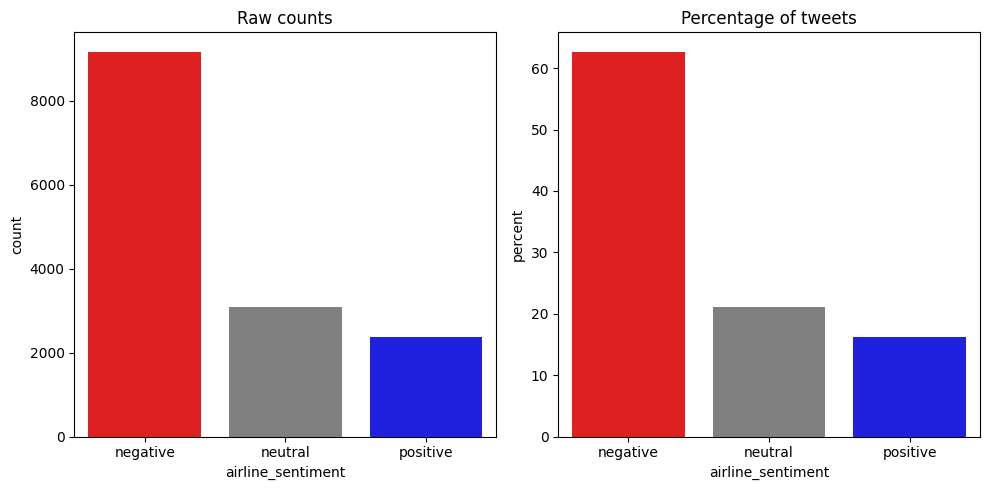

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

labels_col ={"neutral": "gray",
             "positive": "blue",
             "negative": "red"}

sns.countplot(ax= ax[0],data=df,
                      x="airline_sentiment",
                      palette=labels_col,
                      order={"negative": 1, "neutral": 2, "positive": 3}
                      )
ax[0].set_title("Raw counts")

sns.countplot(ax=ax[1],data=df,
              x="airline_sentiment",
              order={"negative": 1, "neutral": 2, "positive": 3},
              palette=labels_col,
              stat="percent")
ax[1].set_title("Percentage of tweets")
fig.tight_layout()


From the plots, we can see that we have an unbalanced dataset with a majority of tweets labeled as positive. With the following numbers:

- 63% are positive
- 21% are neutral
- 16% are negative

This is not strictly necessary but we can also explore the identified negative reasons for the reviews.

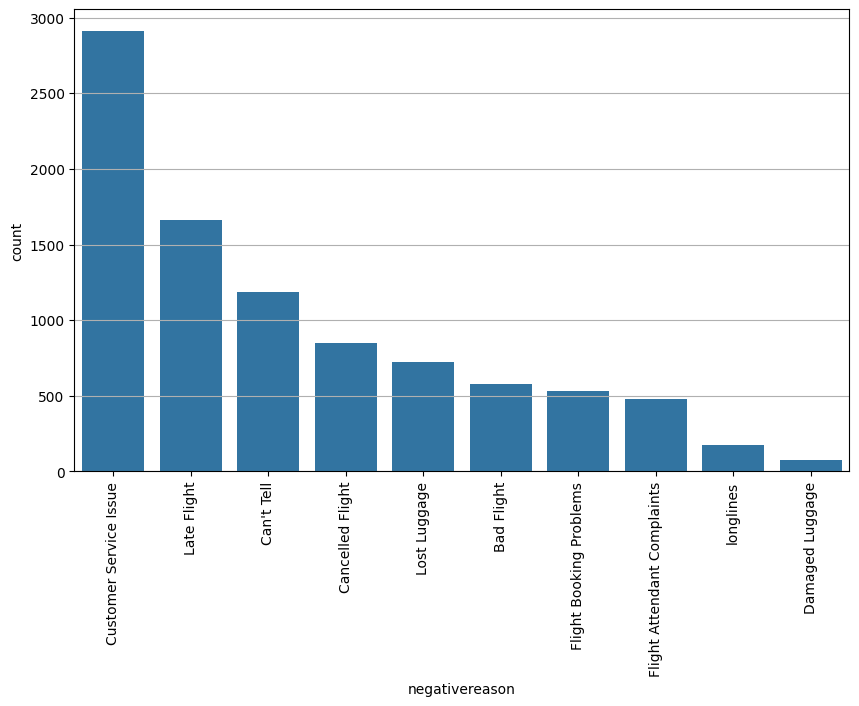

In [18]:
ax = sns.countplot(data =df,
                   x ="negativereason",
                   order=df.negativereason.value_counts().index )
plt.xticks(rotation =90);
ax.yaxis.grid(True) # Show the horizontal gridlines

# 2.Data processing/cleaning

Raw tweet text is not suitable to be directly use in a ML model. We must first process it to remove characters or words that are not useful for the classification problem (sentiment analysis of three classes). To do so we will do the following text transformation:

- remove url
- remove tags
- remove quotation
- lower casing
- remove punctuation
- remove stopwords
- lemmatization

Stopwords are words that are not useful in the discrimination of classes. For instance the word 'the' is very common in English but will not be helpful to determine the sentiment of a tweet so it will be removed. We use the NLTK package (Natural Language Took Kit) to identify the stopword in English and leverage several of the functionalities. The regular expression 're' package is also useful to remove specific characters sequences.


In [19]:
#df2 = df.copy() #let's make a copy

In [20]:
cleaned_txt = df["text"].apply(clean_text) #need to fix this step
df["text_cleaned"] = cleaned_txt
df["text_cleaned"].head()

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text_cleaned, dtype: object

In [21]:
df['text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [22]:
df["text_cleaned"]

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text_cleaned, Length: 14640, dtype: object

In [23]:
df['text_cleaned'].isnull().sum()

0

# *3. Test train split*

We need to split the dataset into training and testing. The training data may also be split into traning and validation. The three dataset serve different purposes:

- training dataset: used to train the model
- validation dataset: used to evaluate the trained model and used to tune the hyperparameters. Hyperparameters are parameters that are not estimated directly from the data but are chosen by the modeler or ML developer.
- test dataset: used to test the performance of the model on never seen data. this dataset must not be used during model development.

In [24]:
del cleaned_txt

In [25]:
from sklearn.model_selection import train_test_split
X = df['text_cleaned']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

We use the train_test_spit function from sklearn keeping 20% of the data for testing. Note also that we stratify the split so that we have samples that are represented in all the three classes (positive, neutral, negative). We also set the random_seed for reproducibility.

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11712,)
(2928,)
(11712,)
(2928,)


We have 11,712 tweets in the training dataset and 2928 tweets in the testing dataset.

# *4. Text Vectorization*

Text vectorization is the process of convert text into a numerical representation. The element of the text called 'token' may be a character, word, group of words (ngrams) or sentences. In the present application, we tokenize individual words. The tokenization step involves counting the number of distinct words in the dataset and assigning integer values to each distinc words. In some cases, we may transform the integer values into a one hot encoded format or keep track of the frequency of each token. In summary we have the following:

- Tokenization: assigning integer numerical values to tokens.
- one hot encoding: one hot encoding matrix of the tokenized item.
- frequency: frequency matrix with frequency for each token

The typical output of the text vectorization step may be a document-term matrix (DT) with document in the rows and token (words) in the column. The matrix may contain 1 or zero int the case of one hot encoding or a frequency count in the case of document term frequency.

We will illustrate the concepts below with mockup data and then apply the textvectorization to the tweets dataset.

# *4.1. Document term frequency: DTF*
https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

https://medium.com/analytics-vidhya/tdm-term-document-matrix-and-dtm-document-term-matrix-8b07c58957e2

In [27]:
# Example of DFT
#https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

from sklearn.feature_extraction.text import CountVectorizer
corpus = [
'Food service was slow and the food was bad and late.',
'The flight was very delayed.',
'Food was cold and very late.',
'I asked for water and coffee but it never came',
]
vectorizer = CountVectorizer()

vect=vectorizer.fit_transform(corpus)
print(type(vect))
print(type(vectorizer))

df_example = pd.DataFrame(data=vect.toarray(),
                          columns = vectorizer.get_feature_names_out())
print(df_example.shape)
df_example


<class 'scipy.sparse._csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.CountVectorizer'>
(4, 20)


,and,asked,bad,but,came,coffee,cold,delayed,flight,food,for,it,late,never,service,slow,the,very,was,water
0,2,0,1,0,0,0,0,0,0,2,0,0,1,0,1,1,1,0,2,0
1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0
2,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0
3,1,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1


Note that if we set binary = False we will get boolean not frequency values. The mockup example shows a matrix with the frequency of each word in a document. The size is 4x20:
- 4 documents (in this case sentences)
- 20 tokens/words

# *4.2. Term Frequency Inverse Document Frequency: TFIDF*

The overall goal is to weight more rare words or words that appear less in the corpus and that are specific to documents. This matrix can then be used in the sentiment analysis classification. In the case of TFIDF, we still have a very large sparse matrix. It can be reduced in dimension or used directly in a classifier.



In [28]:
# Example of DFT
#https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
'Food service was slow and the food was bad and late.',
'The flight was very delayed.',
'Food was cold and very late.',
'I asked for water and coffee but it never came',
]
vectorizer = TfidfVectorizer()
vect=vectorizer.fit_transform(corpus)
print(type(vect))
print(type(vectorizer))

df_example = pd.DataFrame(data=vect.toarray(),
                          columns = vectorizer.get_feature_names_out())
print(df_example.shape)
df_example

<class 'scipy.sparse._csr.csr_matrix'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
(4, 20)


,and,asked,bad,but,came,coffee,cold,delayed,flight,food,for,it,late,never,service,slow,the,very,was,water
0,0.403914,0.000000,0.316404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.498914,0.000000,0.000000,0.249457,0.000000,0.316404,0.316404,0.249457,0.00000,0.403914,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523381,0.523381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.412640,0.41264,0.334067,0.000000
2,0.332748,0.000000,0.000000,0.000000,0.000000,0.000000,0.521314,0.000000,0.000000,0.411010,0.000000,0.000000,0.411010,0.000000,0.000000,0.000000,0.000000,0.41101,0.332748,0.000000
3,0.220133,0.344881,0.000000,0.344881,0.344881,0.344881,0.000000,0.000000,0.000000,0.000000,0.344881,0.344881,0.000000,0.344881,0.000000,0.000000,0.000000,0.00000,0.000000,0.344881


Our mock up example shows a tfidf matrix with 4 documents and 20 tokens/words. These are considered the features that are used in the sentiment analysis modeling.

# *4.3. Tweets TFIDF*

Let's now apply TFIDF to the tweets dataset using sklearn. We will use the following arguments:

- preprocessor: pass the preprocessing function we created to clean the data.
- min_df: tokens must appear at least three times in different in order to be considered.

There are other arguments such as ngram to consider multiple words together or max_features that will limit the tokens to the a maximum number of most frequent token (taken in the order of frequency).

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=clean_text,
                             min_df=3
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#https://www.kaggle.com/code/halitvural/tweet-analysis-using-ml-algorithms-with-tf-idf

# *5. Model building*

We have now encoded our text data into numerical values using TFIDF and we can use the features create into a ML model. For this exercise, we use the random forest classifier from sklearn. We will use the following arguments:

- n_estimators: number of trees we will generate, we use the default value of 100.
- max_depth:
- random_state:
- n_jobs


In [30]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=40,
                                  random_state=42,
                                  n_jobs=-1)
model_rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

# *6. Model evaluation*


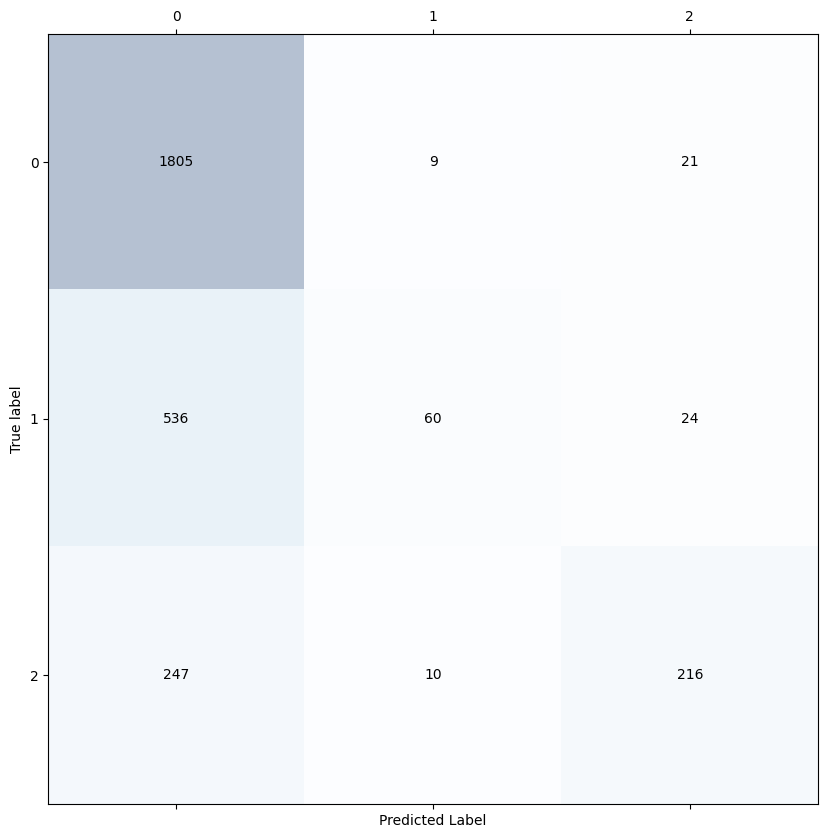

In [31]:
y_pred_test = model_rf.predict(X_test_tfidf)
y_train_test = model_rf.predict(X_train_tfidf)

#report_model('Random Forest', rf_pred, rf_train_pred)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#y_pred_test = y_pred_test_df['y_pred_test']
report_dict=classification_report(y_test,
                                      y_pred_test,
                                      output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(y_test,y_pred_test)

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(confusion_matrix_val,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confusion_matrix_val.shape[0]):
  for j in range(confusion_matrix_val.shape[1]):
    ax.text(x=j,y=i,
               s=confusion_matrix_val[i,j],
               va='center',
               ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True label')

In [32]:
report_df

,precision,recall,f1-score,support
negative,0.697450,0.983651,0.816188,1835.000000
neutral,0.759494,0.096774,0.171674,620.000000
positive,0.827586,0.456660,0.588556,473.000000
accuracy,0.710724,0.710724,0.710724,0.710724
macro avg,0.761510,0.512362,0.525473,2928.000000
weighted avg,0.731610,0.710724,0.642941,2928.000000


# *7. Save model arfifacts for prediction/inference*

The last step is to save the model for inference. We serialize the model using pickle (another option is joblib). We must also serialize the tifidf vectorizer object. These two objects are called model artifacts and can be used when serving the model online using for instance a REST API.

For this exercise, we test the model by reloading the serialized model and provding a text string to predict its sentiment.

Useful links and references:

- https://blaza-matt.com/mlops-simplified-what-is-an-artifact-684b64e9f60



In [33]:
import pickle
pickle.dump(model_rf, open('model_rf.pkl','wb'))

pickle.dump(vectorizer,open('tfidf_vectorizer.pkl','wb'))

In [34]:
# Loading model to compare the results
model2 = pickle.load(open('model_rf.pkl','rb'))
tfidf_vectorizer2 = pickle.load(open('tfidf_vectorizer.pkl','rb'))

In [35]:
sample="The meal service was not very good and we didn't get water"

In [36]:
sample_cleaned = clean_text(sample)
sample_processed = X_test_tfidf = vectorizer.transform([sample_cleaned])
y_pred_test2 = model_rf.predict(sample_processed)
y_pred_test2
#prediction is negative

array(['negative'], dtype=object)

#End of script